In [2]:
# Load dependencies

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter, Constraint)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

# Set up MORO

# Initialize model parameters
from model.dike_model_function import DikeNetwork  # @UnresolvedImport
from model.problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(5)

# Define robustness functions

# Rebustness score
def robustness(data):
    ''' 
    Returns a robustness score for a value you want to minimize.
    s
    We want a function that returns 0 for the outcome to be in the range that we want and higher otherwise.
    
    Takes in an array and returns a score for each value of the same array.
    '''
    
    # Normalize
    mean = np.mean(data)
    iqr = np.quantile(data,0.75,axis=0) - np.quantile(data,0.25,axis=0) + mean * 0.005 # Add a small number so the mean is still considered in the score rather than 0
    score = mean * iqr
    
    return score

def sumover_robustness(*data):
    '''
    Used to aggregate each outcome's varying location and time into one robustness score.
    
    Input: multiple n-length (but same) arrays and sums up element-wise into a [1,n] array
    
    Returns: asks the robustness function to calculate a score for the [1,n] array.
    '''
    return robustness(np.sum(data, axis=1))

# Initialize some vars to make `robustness_functions` a bit more read-able
var_list_damage = ['A.1_Expected Annual Damage 0','A.1_Expected Annual Damage 1','A.1_Expected Annual Damage 2',
                   'A.2_Expected Annual Damage 0','A.2_Expected Annual Damage 1','A.2_Expected Annual Damage 2',
                   'A.3_Expected Annual Damage 0','A.3_Expected Annual Damage 1','A.3_Expected Annual Damage 2',
                   'A.4_Expected Annual Damage 0','A.4_Expected Annual Damage 1','A.4_Expected Annual Damage 2',
                   'A.5_Expected Annual Damage 0','A.5_Expected Annual Damage 1','A.5_Expected Annual Damage 2']
var_list_deaths = ['A.1_Expected Number of Deaths 0','A.1_Expected Number of Deaths 1','A.1_Expected Number of Deaths 2',
                   'A.2_Expected Number of Deaths 0','A.2_Expected Number of Deaths 1','A.2_Expected Number of Deaths 2',
                   'A.3_Expected Number of Deaths 0','A.3_Expected Number of Deaths 1','A.3_Expected Number of Deaths 2',
                   'A.4_Expected Number of Deaths 0','A.4_Expected Number of Deaths 1','A.4_Expected Number of Deaths 2',
                   'A.5_Expected Number of Deaths 0','A.5_Expected Number of Deaths 1','A.5_Expected Number of Deaths 2']
var_list_dike = ['A.1_Dike Investment Costs 0','A.1_Dike Investment Costs 1','A.1_Dike Investment Costs 2',
                 'A.2_Dike Investment Costs 0','A.2_Dike Investment Costs 1','A.2_Dike Investment Costs 2',
                 'A.3_Dike Investment Costs 0','A.3_Dike Investment Costs 1','A.3_Dike Investment Costs 2',
                 'A.4_Dike Investment Costs 0','A.4_Dike Investment Costs 1','A.4_Dike Investment Costs 2',
                 'A.5_Dike Investment Costs 0','A.5_Dike Investment Costs 1','A.5_Dike Investment Costs 2']
var_list_rfr = ['RfR Total Costs 0', 'RfR Total Costs 1', 'RfR Total Costs 2']
var_list_evac = ['Expected Evacuation Costs 0', 'Expected Evacuation Costs 1', 'Expected Evacuation Costs 2']

def aggregate_outcomes(results, outcome):
    list_outcomes_columns = []
    
    for i in results.columns:
        if outcome in i:
            list_outcomes_columns.append(i)
            
    results["Total " + str(outcome)] = results[list_outcomes_columns].sum(axis = 1)

C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Find the ranges for epsilon and hypervolume convergence

To set $\epsilon$ values, we must minimize noise by first running a robust optimize quickly to see a Pareto front develop as stated in section 3.4 of doi: 10.1016/j.envsoft.2011.04.003 (we don't only look at Monte Carlo policies in hope that this will save time).

In [2]:
results = utilities.load_results('Outcomes/400Scenarios75Policies.csv')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from /Users/jrwang/Documents/Coding/Model-based-decision-making/Outcomes/400Scenarios75Policies.csv


In [3]:
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")

# Aggregate
aggregate_outcomes(outcomes,"Expected Annual Damage")
aggregate_outcomes(outcomes,"Dike Investment Costs")
aggregate_outcomes(outcomes,"Expected Number of Deaths")
aggregate_outcomes(outcomes,"RfR Total Costs")
aggregate_outcomes(outcomes,"Expected Evacuation Costs")

everything = pd.DataFrame(experiments["policy"]).join(outcomes)

# Run robustness, find the 75th quantile (or 0,max)
robust_values = everything.groupby(by = ["policy"]).apply(robustness).iloc[:, -5:]
hyp_ranges_min = robust_values.apply(np.min)
hyp_ranges_max = robust_values.apply(np.max)
robust_values.quantile(0.75)

Total Expected Annual Damage       2.424605e+14
Total Dike Investment Costs        8.016821e+18
Total Expected Number of Deaths    7.593013e-06
Total RfR Total Costs              8.500209e+15
Total Expected Evacuation Costs    1.333967e+05
Name: 0.75, dtype: float64

In [4]:
hyp_ranges_min

Total Expected Annual Damage       0.000000e+00
Total Dike Investment Costs        4.380159e+17
Total Expected Number of Deaths    0.000000e+00
Total RfR Total Costs              1.146726e+15
Total Expected Evacuation Costs    0.000000e+00
dtype: float64

In [5]:
hyp_ranges_max

Total Expected Annual Damage       1.824331e+16
Total Dike Investment Costs        5.209281e+19
Total Expected Number of Deaths    3.718098e-03
Total RfR Total Costs              1.616582e+16
Total Expected Evacuation Costs    2.238656e+07
dtype: float64

In [3]:
# Define model parameters so we can run robust_optimize and find valid epsilon values.
MINIMIZE = ScalarOutcome.MINIMIZE

# These functions need to only return one value...

robustness_functions = [
    ScalarOutcome('Damage Score', variable_name = var_list_damage,
                  function = sumover_robustness, kind = MINIMIZE),    
    ScalarOutcome('Deaths Score', variable_name = var_list_deaths,
                  function = sumover_robustness, kind = MINIMIZE),
    ScalarOutcome('Dike Invest Score', variable_name = var_list_dike,
                  function = sumover_robustness, kind = MINIMIZE),
    ScalarOutcome('RfR Invest Score', variable_name = var_list_rfr,
                  function = sumover_robustness, kind = MINIMIZE),
    ScalarOutcome('Evac Score', variable_name = var_list_evac,
                  function = sumover_robustness, kind = MINIMIZE),
]

constraints = [Constraint("discount_for_rfr_0", outcome_names="RfR Total Costs 0",
                          function=lambda x:max(0, x-426.24)),
               Constraint("discount_for_rfr_1", outcome_names="RfR Total Costs 1",
                          function=lambda x:max(0, x-284.16)),
               Constraint("discount_for_rfr_2", outcome_names="RfR Total Costs 2",
                          function=lambda x:max(0, x-142.08))]

In [7]:
# from ema_workbench import ema_logging
# from ema_workbench.em_framework.optimization import (HyperVolume, 
#                                                      EpsilonProgress)
# from ema_workbench.em_framework.evaluators import BaseEvaluator

# BaseEvaluator.reporting_frequency = 0.1
# ema_logging.log_to_stderr(ema_logging.INFO)

# epsilons = [0.05,]*len(robustness_functions)

# start = time.time()

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results, convergence = evaluator.robust_optimize(robustness_functions,
#                                                      scenarios=10,
#                                                      nfe=200,
#                                                      epsilons=epsilons,
#                                                      convergence=[EpsilonProgress()],
#                                                      convergence_freq=1,
#                                                      constraint=constraints
#                                                     )

# end = time.time()
# print("Time taken: {:0.5f} minutes".format((end - start)/60))

In [8]:
# with open('Outcomes/initial_Pareto_policies.pkl', 'wb') as file_pi:
#     pickle.dump(results, file_pi)

In [9]:
with open('Outcomes/initial_Pareto_policies.pkl', 'rb') as file_pi:
    results = pickle.load(file_pi)

Now that we can some policies somewhere on a Pareto front, we can run them under more scenarios and see the variance of their values across those scenarios.

In [10]:
# policies = []
# for row in range(results.shape[0]):
#     policies.append(
#         Policy(name = row, **results.iloc[row,:-5].to_dict())  # Do not include the damage scores
#     )
    
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=50,policies=policies)

In [11]:
# with open('Outcomes/epsilon_results.pkl', 'wb') as file_pi:
#     pickle.dump(results, file_pi)

In [12]:
with open('Outcomes/epsilon_results.pkl', 'rb') as file_pi:
    results = pickle.load(file_pi)

In [13]:
experiments, outcomes = results

outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")

aggregate_outcomes(outcomes,"Expected Annual Damage")
aggregate_outcomes(outcomes,"Dike Investment Costs")
aggregate_outcomes(outcomes,"Expected Number of Deaths")
aggregate_outcomes(outcomes,"RfR Total Costs")
aggregate_outcomes(outcomes,"Expected Evacuation Costs")

everything = pd.DataFrame(experiments["policy"]).join(outcomes)

robust_values = everything.groupby(by = ["policy"]).apply(robustness).iloc[:, -5:]

# Finally, find the IQR ranges that are our 'noise-adjusted epsilon values'
ranges = robust_values.apply(sp.stats.iqr)

### Subset the worst case conditions

In [19]:
# From CART Analysis for deaths and damages (see BaseCase.ipynb)

dike_model.uncertainties['A.1_pfail'] = RealParameter('A.1_pfail', 0, 0.367)
dike_model.uncertainties['A.3_pfail'] = RealParameter('A.3_pfail', 0, 0.226)

## Run MORO!

In [14]:
from ema_workbench import ema_logging
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 1 #50
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = int(6)

# The expected ranges are set to minimize noise as discussed in section 3.4 of doi: 10.1016/j.envsoft.2011.04.003
epsilons = ranges.values
convergence = [HyperVolume(hyp_ranges_min,hyp_ranges_max),
              EpsilonProgress()]

# Time the output
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions,
                                                     scenarios = scenarios,
                                                     nfe=nfe,
                                                     epsilons=epsilons,
                                                     convergence=convergence,
                                                     convergence_freq=20,
                                                     logging_freq=10,
                                                     constraint=constraints
                                                    )

end = time.time()
print("Time taken: {:0.5f} minutes".format((end - start)/60))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/6 nfe
[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool


Time taken: 0.73733 minutes


In [18]:
import pickle

filename = 'Outcomes/MORO_s' + str(n_scenarios) + '_nfe' + str(nfe) + '.pkl'
with open(filename, 'wb') as file_pi:
    pickle.dump((results, convergence), file_pi)

## Quickly check for convergence

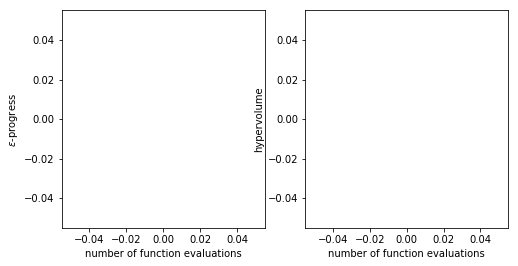

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [1]:
import pickle

results_MORO, convergence = pickle.load(open('Outcomes/MORO_s50_nfe20000.pkl', 'rb'))

In [7]:
results_MORO.iloc[:, -5:]

,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score
0,1.964370e+14,1.861056e-06,1.196531e+18,1.178112e+16,3.252648e+08
1,1.133849e+11,1.143893e-07,1.196531e+18,9.305655e+18,0.000000e+00
2,7.853715e+11,9.160793e-08,1.196531e+18,6.272040e+18,1.574746e+06
3,1.964370e+14,1.292400e-04,1.196531e+18,1.178112e+16,0.000000e+00
4,1.980599e+14,1.307336e-04,1.196531e+18,7.906444e+17,0.000000e+00
5,4.577942e+14,3.845736e-04,1.501146e+18,0.000000e+00,0.000000e+00
6,4.577942e+14,8.652907e-06,1.501146e+18,0.000000e+00,2.928564e+08
7,4.577942e+14,5.537860e-06,1.501146e+18,0.000000e+00,4.520066e+08
8,1.161485e+15,7.686822e-04,1.196531e+18,0.000000e+00,0.000000e+00


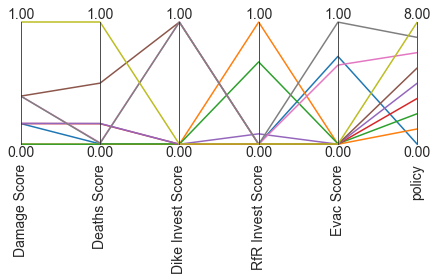

,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score,policy
0,0.169045,0.002302,0.000000e+00,0.001266,0.719602,0
1,0.000000,0.000030,0.000000e+00,1.000000,0.000000,1
2,0.000579,0.000000,0.000000e+00,0.674003,0.003484,2
3,0.169045,0.168033,2.167261e-07,0.001266,0.000000,3
4,0.170442,0.169976,1.118503e-07,0.084964,0.000000,4
5,0.394087,0.500243,1.000000e+00,0.000000,0.000000,5
6,0.394087,0.011139,1.000000e+00,0.000000,0.647903,6
7,0.394087,0.007086,1.000000e+00,0.000000,1.000000,7
8,1.000000,1.000000,2.114056e-07,0.000000,0.000000,8


In [47]:
from ema_workbench.analysis import parcoords

data = results_MORO.loc[:, [o.name for o in robustness_functions]]
data_norm = (data - data.min()) / (data.max() - data.min())
data_norm["policy"] = data.index # Adding a Policy column to easier identify which line belongs to which policy
limits = parcoords.get_limits(data_norm)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_norm)
plt.show()
data_norm